# MNIST Tensor flow example
E. Krupczak - 18 Aug 2018

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

#Import mnist data, which comes with tensor flow
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Components of MNIST
- mnist.train
- mnist.test
- mnist.validation
Each with images and labels

In [ ]:
mnist.train.labels

In [ ]:
mnist.train.labels.shape

In [ ]:
#This is a six
mnist.train.labels[600]

In [ ]:
#this is the first image
plt.matshow(mnist.train.images[600].reshape((28,-1)))

In [2]:
# Function to make weight and bias variables
# Number of weight variables: 784*number of nodes in next layer
# Number of bias (i.e. offset/intercept) variables: number of nodes in next layer

def weight_variable(shape):
    '''For matrix multiplication in fully-connected layers, weight variable shape is: input size * output size.'''
    #Normally distributed variables clamped between 0-1 with stddev as given
    initial = tf.truncated_normal(shape, stddev=0.1)
    #Return variable node
    return tf.Variable(initial)

def bias_variable(shape):
    ''' Bias variable shape is number of loads in next layer. '''
    #Slightly positive so we preserve more gradients for RELU non-linearity 
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

In [3]:
#input placeholder - 28x28 represented as a 784-length vector
input_ph = tf.placeholder(tf.float32, shape=[None,28*28], name = 'input_ph')
#output placeholder - a 10-length vector containing logits
output_ph = tf.placeholder(tf.float32, shape=[None,10], name = 'output_ph')

#flow stores current node as we process through the layers
#Starts by pointing to placeholder node for input
flow = input_ph

#Make some layers
def make_layer(n):
    global flow
    #Use the shape of the previous layer to make the weight variable for the next
    w1 = weight_variable((int(flow.shape[-1]), n))
    b1 = bias_variable((n,))
    #right-multiply by the weight
    #flow points to computational node
    flow = tf.matmul(flow,w1)+b1
    
def make_nonlinearity():
    '''rectified linear'''
    global flow
    #updates computational node held by flow
    flow = tf.nn.relu(flow)
    
#Intersperse nonlinearity between the affine layers
#Layer 1 - 100 nodes
make_layer(100)
make_nonlinearity()
#Layer 2 - 50 nodes
make_layer(50)
make_nonlinearity()
#Layer 3 (output) - 10 nodes
make_layer(10)

network_output = flow

#Make loss computational node (returns loss as a number)
##Simplest loss function (squared error)
#loss = tf.reduce_mean((output_ph - network_output)**2)
##Cross-entropy loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=output_ph, 
    logits=network_output, #unnormalized log probabilities of label classes
))

##Accuracy nodes
accuracy = tf.reduce_mean(tf.cast(
    tf.equal(tf.argmax(network_output,1), tf.argmax(output_ph,1)),
    tf.float32,
))

#Gradient descent with 'GradientDescentOptimizer'
learning_rate = 0.1
#make training step computational node (has only side effects; returns none)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

#Make a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [4]:
val_loss_list = []
in_sample_loss_list = []
accuracy_list = []

In [14]:
#Train the model
minibatchsize = 32
for i in range(40):
    #Compute loss and accuracy across validation set
    val_acc, val_loss = sess.run([accuracy,loss], feed_dict={
        input_ph: mnist.validation.images,
        output_ph: mnist.validation.labels,
    })
    #Compute loss in sample
    in_sample_loss = sess.run(loss, feed_dict={
        input_ph: mnist.train.images,
        output_ph: mnist.train.labels,
    })
    
    accuracy_list.append(val_acc)
    val_loss_list.append(val_loss)
    in_sample_loss_list.append(in_sample_loss)
    
    for j in range(100):
        minibatch_indices = random.sample(range(len(mnist.train.labels)),minibatchsize)
        sess.run(train_step, feed_dict={
            input_ph: [mnist.train.images[i] for i in minibatch_indices],
            output_ph: [mnist.train.labels[i] for i in minibatch_indices],
        })
    print('Step:', len(val_loss_list)*100, ' Validation:', val_loss, 'In-sample:', in_sample_loss, 'Acc:', val_acc)

Step: 4100  Validation: 0.11132942 In-sample: 0.094212644 Acc: 0.9674
Step: 4200  Validation: 0.107897386 In-sample: 0.092770755 Acc: 0.9652
Step: 4300  Validation: 0.10337444 In-sample: 0.0904911 Acc: 0.9702
Step: 4400  Validation: 0.102774575 In-sample: 0.08517225 Acc: 0.9704
Step: 4500  Validation: 0.107951194 In-sample: 0.08475783 Acc: 0.9676
Step: 4600  Validation: 0.11713794 In-sample: 0.09578929 Acc: 0.9646
Step: 4700  Validation: 0.10675399 In-sample: 0.082872376 Acc: 0.9682
Step: 4800  Validation: 0.10585072 In-sample: 0.08482863 Acc: 0.9668
Step: 4900  Validation: 0.10471206 In-sample: 0.08423912 Acc: 0.9658
Step: 5000  Validation: 0.0969524 In-sample: 0.07277669 Acc: 0.969
Step: 5100  Validation: 0.09997456 In-sample: 0.07641756 Acc: 0.968
Step: 5200  Validation: 0.100301586 In-sample: 0.075224414 Acc: 0.967
Step: 5300  Validation: 0.09873586 In-sample: 0.072087266 Acc: 0.9692
Step: 5400  Validation: 0.09464411 In-sample: 0.068617925 Acc: 0.9716
Step: 5500  Validation: 0.105

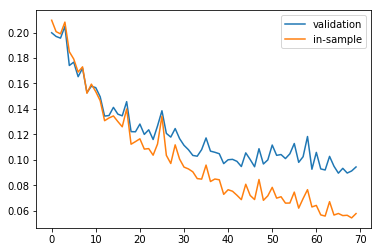

In [15]:
plt.plot(val_loss_list[10:])
plt.plot(in_sample_loss_list[10:])
plt.legend(['validation', 'in-sample'])

In [ ]:
#Run the model on the test images
model_output = sess.run(network_output, feed_dict={
    input_ph:mnist.test.images[0:10],
})

In [ ]:
model_output[0]

In [ ]:
def softmax(x):
    x = np.exp(x)
    return x/x.sum()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.matshow([softmax(x) for x in model_output])
ax2.matshow(mnist.test.labels[0:10])

In [ ]:
plt.matshow(mnist.test.images[8].reshape((28,28)))